# Sales anomaly detection using PyOD
I believe it's important to go over a basic example of a univariate anomaly detection method, which finds outliers from a distribution of values in a single feature space, before moving on to multivariate anomaly identification.


In [1]:
!pip install combo

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.ensemble import IsolationForest

## 2. Load the dataset
The dataset that we are using is the Super Store Sales data set, and we are going to find patterns in Sales and Profit separately that do not confirm to expected behavior. That is, spotting outliers for one variable at a time.

In [3]:
df = pd.read_excel("Sample_Superstore.xls")

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df['Sales'].head()

0    261.9600
1    731.9400
2     14.6200
3    957.5775
4     22.3680
Name: Sales, dtype: float64

Let's see the distribution of sales

In [6]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

Plot

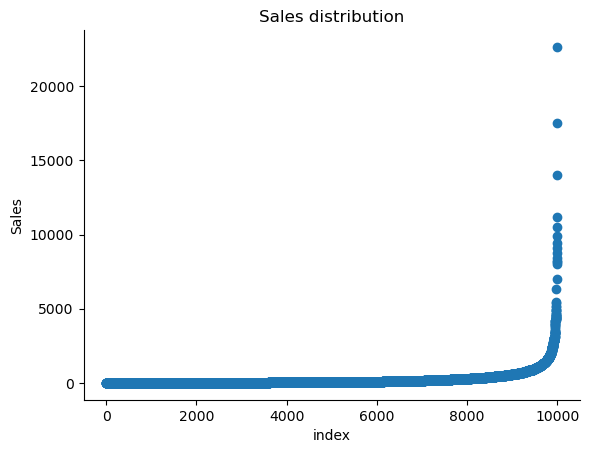

In [7]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

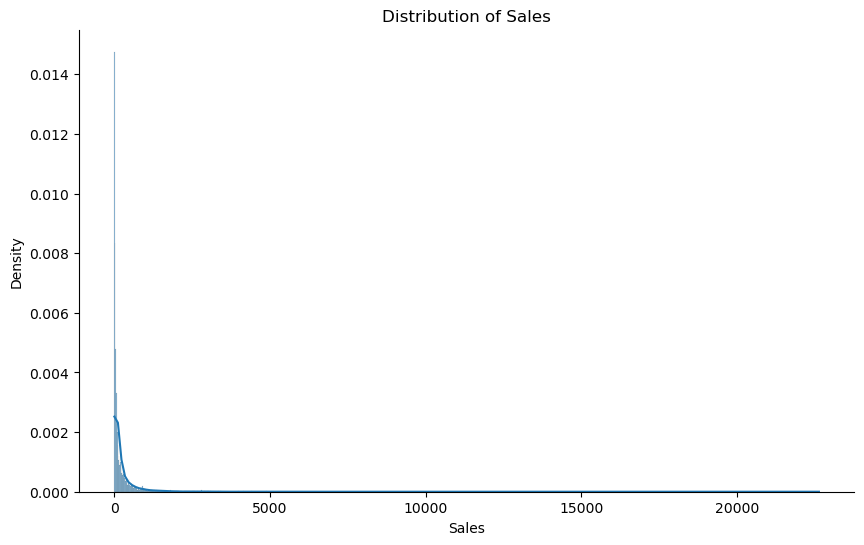

In [8]:
#Create a larger figure
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(df['Sales'], kde=True, stat="density")
plt.title("Distribution of Sales")
sns.despine()

# Show the plot
plt.show()

In [9]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


The Superstore’s sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail sales distribution far exceeds the tails of the normal distribution.

There are one region where the data has low probability to appear which is on the right side of the distribution.

Let's check the distribution of another feature called `Profit`

In [10]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

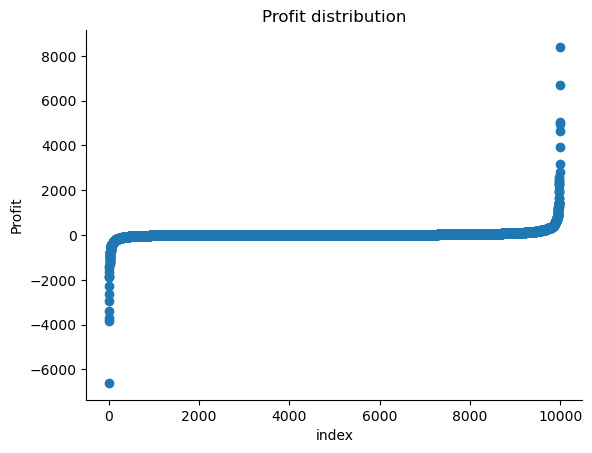

In [11]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

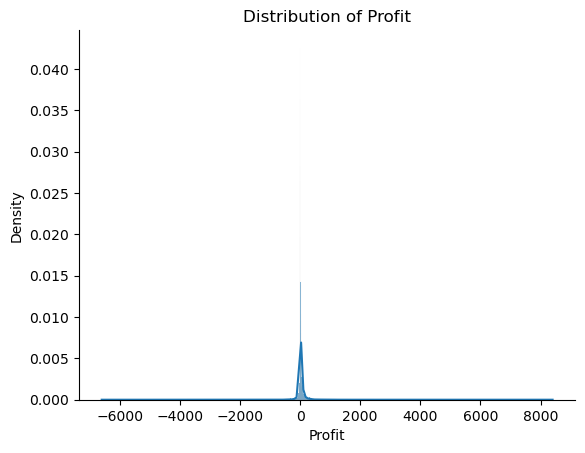

In [12]:
# Plot the histogram
sns.histplot(df['Profit'], kde=True, stat="density")
plt.title("Distribution of Profit")
sns.despine()


In [13]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


The Superstore’s Profit distribution has both a positive tail and negative tail. However, the positive tail(More than 8000) is longer than the negative tail(Almost -6000). So the distribution is positive skewed, and the data are heavy-tailed or profusion of outliers.

There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

## 3. Univariate Anomaly Detection
Let's first perform univariate anomaly detection using an ISolationForest algorithm. The IsolationForest technique, which is predicated on the idea that anomalies are data points that are rare and distinct, is used to identify outliers and yields the anomaly score of each sample. The model Isolation Forest is based on trees. To build partitions in these trees, a feature is first randomly selected, and then a random split value between the minimum and maximum value of the selected feature is selected.

### 3(a) Using Sales
Here, we only using `Sales` feature to detect anomalies.

Let's create an ISolationForest model instance and fit the model on sales data.

In [14]:
iF = IsolationForest(n_estimators=100) # Only using 100 estimators
iF.fit(df['Sales'].values.reshape(-1, 1))

IsolationForest()

Now store the Sales in an array and compute the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

In [15]:
X = df['Sales'].values.reshape(-1, 1)
X.shape

(9994, 1)

Compute the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

In [16]:
anomaly_score = iF.decision_function(X)

In [17]:
anomaly_score

array([ 0.0123858 , -0.05201405,  0.10427237, ...,  0.01667486,
        0.09626355,  0.02420478])

Predict Outliers: Classified each observation as an outlier or non-outlier.

In [18]:
outlier = iF.predict(X)

Create a plot that will visualize and highlights the regions where the outliers fall.

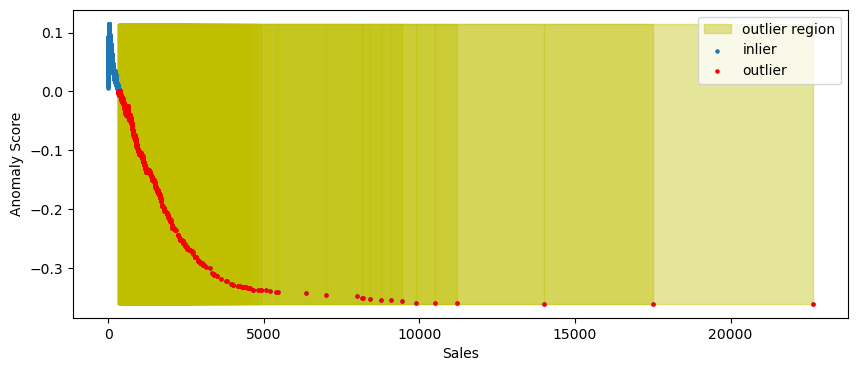

In [19]:
plt.figure(figsize=(10, 4))
plt.fill_between(X[:, 0], np.min(anomaly_score), np.max(anomaly_score),
                 where=(outlier == -1), color='y',
                 alpha=0.4, label='outlier region')
plt.scatter(X[:, 0], anomaly_score, label='inlier',  marker='o', s=5)
plt.scatter(X[outlier == -1, 0], anomaly_score[outlier == -1], c='r', label='outlier', marker='o', s=5)


plt.legend()
plt.ylabel('Anomaly Score')
plt.xlabel('Sales')
plt.show()


According to the above results and visualization, It seems that Sales that exceeds 1000 would be definitely considered as an outlier.

Let's visually inspect one anomaly.

In [20]:
df_anomalies = df[outlier == -1]

In [21]:
df_anomalies.iloc[9]

Row ID                            36
Order ID              CA-2016-117590
Order Date       2016-12-08 00:00:00
Ship Date        2016-12-10 00:00:00
Ship Mode                First Class
Customer ID                 GH-14485
Customer Name              Gene Hale
Segment                    Corporate
Country                United States
City                      Richardson
State                          Texas
Postal Code                    75080
Region                       Central
Product ID           TEC-PH-10004977
Category                  Technology
Sub-Category                  Phones
Product Name             GE 30524EE4
Sales                       1097.544
Quantity                           7
Discount                         0.2
Profit                      123.4737
Name: 35, dtype: object

This purchase seems normal to me expect it was a larger amount of sales compared with the other orders in the data.

### 3(b) Using Profit
Here, we only using `Profit` feature to detect anomalies.

Let's repeat the process of 3a

In [22]:
X = df['Profit'].values.reshape(-1, 1)
X.shape

(9994, 1)

In [23]:
iF = IsolationForest(n_estimators=100) # Only using 100 estimators
iF.fit(X)

IsolationForest()

In [24]:
anomaly_score = iF.decision_function(X)

In [25]:
anomaly_score

array([ 0.10411498, -0.06427176,  0.16734529, ...,  0.14479482,
        0.15287682,  0.06041744])

In [26]:
outlier = iF.predict(X)

Finally, visualize

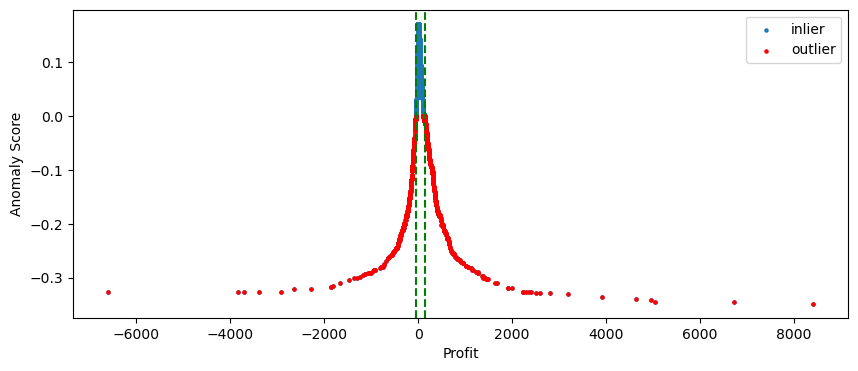

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))

# Plot inliers and outliers
plt.scatter(X[:, 0], anomaly_score, label='inlier', marker='o', s=5)
plt.scatter(X[outlier == -1, 0], anomaly_score[outlier == -1], c='r', label='outlier', marker='o', s=5)

# Find the minimum profit value among inliers
min_inlier_profit = X[outlier == 1, 0].min()

# Find the maximum profit value among inliers
max_inlier_profit = X[outlier == 1, 0].max()

# Sort outlier profits and find the first one before the minimum inlier profit
outlier_profits = X[outlier == -1, 0]
outlier_profits_sorted = np.sort(outlier_profits)
first_outlier_before_inlier = outlier_profits_sorted[outlier_profits_sorted < min_inlier_profit][-1]

# Sort outlier profits and find the first one after the maximum inlier profit
outlier_profits = X[outlier == -1, 0]
outlier_profits_sorted = np.sort(outlier_profits)
first_outlier_after_inlier = outlier_profits_sorted[outlier_profits_sorted > max_inlier_profit][0]

# Draw vertical line for the first profit outlier before inlier
plt.axvline(first_outlier_before_inlier, color='g', linestyle='--')

# Draw vertical line for the first profit outlier before inlier
plt.axvline(first_outlier_after_inlier, color='g', linestyle='--')

plt.legend()
plt.ylabel('Anomaly Score')
plt.xlabel('Profit')
plt.show()


In [28]:
print(f"Range of Profit Inside where inliers falls:({first_outlier_before_inlier} to {first_outlier_after_inlier}) ", )

Range of Profit Inside where inliers falls:(-53.270399999999995 to 134.9925) 


According to the above results and visualization, It seems that Profit that below -80 or exceeds 132 would be considered as an outlier;

In [29]:
df_anomalies = df[outlier == -1]

In [30]:
df_anomalies.iloc[9]

Row ID                                          73
Order ID                            US-2015-134026
Order Date                     2015-04-26 00:00:00
Ship Date                      2015-05-02 00:00:00
Ship Mode                           Standard Class
Customer ID                               JE-15745
Customer Name                           Joel Eaton
Segment                                   Consumer
Country                              United States
City                                       Memphis
State                                    Tennessee
Postal Code                                  38109
Region                                       South
Product ID                         FUR-CH-10000513
Category                                 Furniture
Sub-Category                                Chairs
Product Name     High-Back Leather Manager's Chair
Sales                                      831.936
Quantity                                         8
Discount                       

Any negative profit would be an anomaly and should be further investigate, this goes without saying

In [31]:
df_anomalies.iloc[29]

Row ID                                                  233
Order ID                                     US-2017-100930
Order Date                              2017-04-07 00:00:00
Ship Date                               2017-04-12 00:00:00
Ship Mode                                    Standard Class
Customer ID                                        CS-12400
Customer Name                            Christopher Schild
Segment                                         Home Office
Country                                       United States
City                                                  Tampa
State                                               Florida
Postal Code                                           33614
Region                                                South
Product ID                                  FUR-TA-10003473
Category                                          Furniture
Sub-Category                                         Tables
Product Name     Bretford Rectangular Co

Our model determined that this order with a large profit is an anomaly. However, when we investigate this order, it could be just a product that has a relatively high margin.

The above two visualizations show the anomaly scores and highlighted the regions where the outliers are. As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.

But univariate analysis is only going to take us so far. It's possible that some of the anomalies identified by our models are not what we had anticipated. The approaches to anomaly identification get more technically and computationally demanding when our data is multidimensional rather than univariate.

## 4. Multivariate Anomaly Detection
So, using the Sales and Profit variables, we are going to build an unsupervised multivariate anomaly detection method based on several models.

**Sales & Profit**

When we are in business, we expect that Sales & Profit are positive correlated(When one variable increases, the other variable also tends to increase, and when one variable decreases, the other variable also tends to decrease). If some of the Sales data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further investigated.

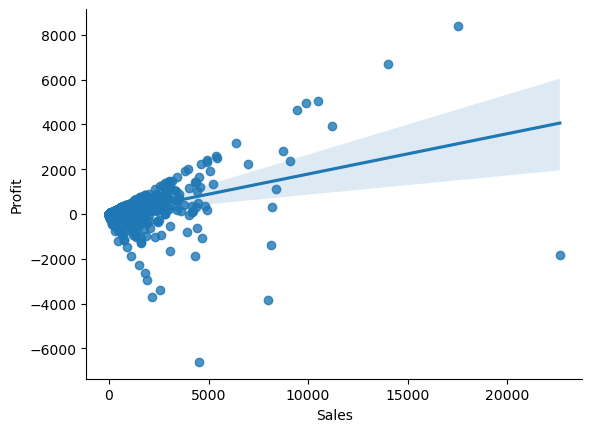

In [32]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values.

<Axes: xlabel='Sales', ylabel='Profit'>

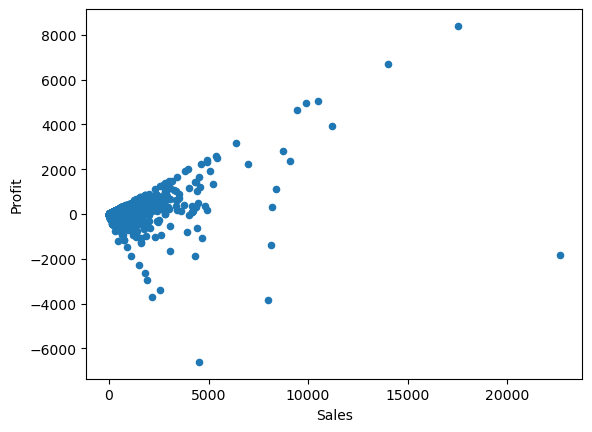

In [33]:
df.plot.scatter('Sales','Profit')

let's implement some of the anomaly detection model provided my PyOD libraries.

In [34]:
from sklearn.preprocessing import MinMaxScaler

df1 = df.copy()
# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df1[['Sales','Profit']] = scaler.fit_transform(df1[['Sales','Profit']])
df1[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [35]:
#Store these values in the NumPy array for using in our models later:

X1 = df1['Sales'].values.reshape(-1,1)
X2 = df1['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [36]:
X.shape

(9994, 2)

You can set the value of the outlier fraction according to your problem and your understanding of the data. In our example, I want to detect 1% observations that are not similar to the rest of the data. So, I’m going to set the value of outlier fraction as 0.01.

In [37]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.01

In [38]:
# Define six outlier detection tools to be compared
classifiers = {
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

Now, we will fit the data to each model one by one and see how differently each model predicts the outliers.

In [39]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

In [40]:
print(xx.shape)
print(yy.shape)

(200, 200)
(200, 200)


/home/surajkarki/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of OUTLIERS :  100 No. of INLIERS :  9894 Cluster-based Local Outlier Factor (CBLOF)


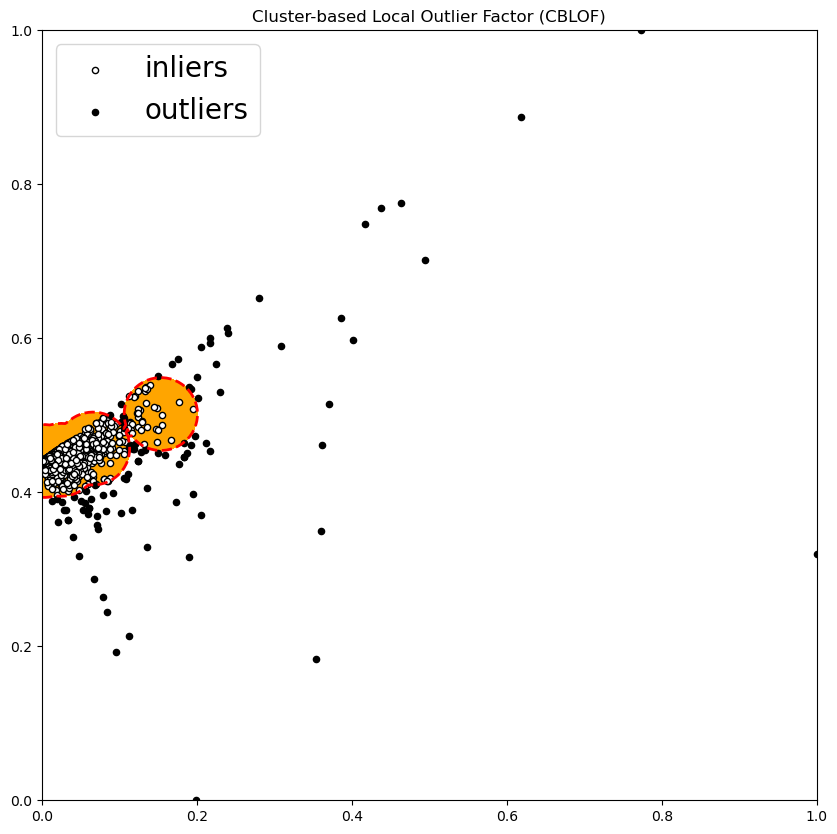

No. of OUTLIERS :  95 No. of INLIERS :  9899 Feature Bagging


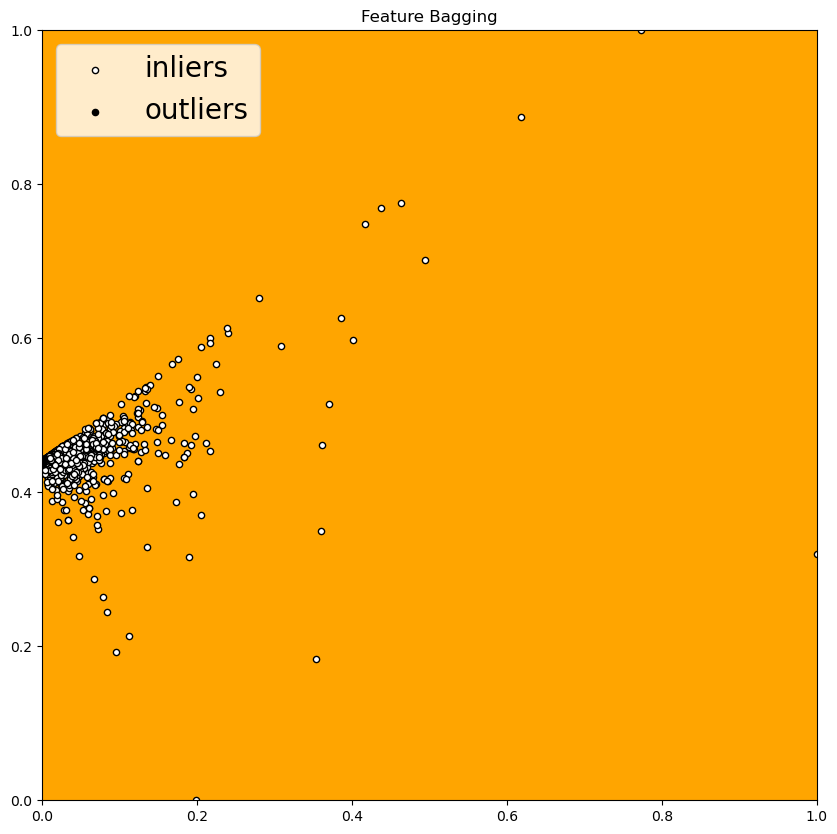

No. of OUTLIERS :  90 No. of INLIERS :  9904 Histogram-base Outlier Detection (HBOS)


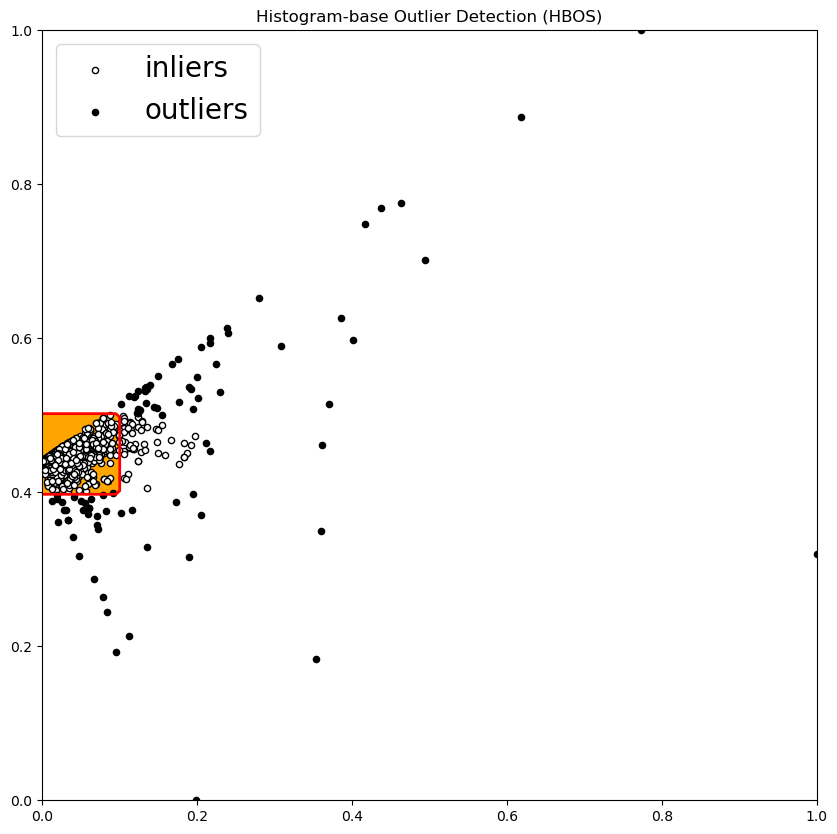

No. of OUTLIERS :  100 No. of INLIERS :  9894 Isolation Forest


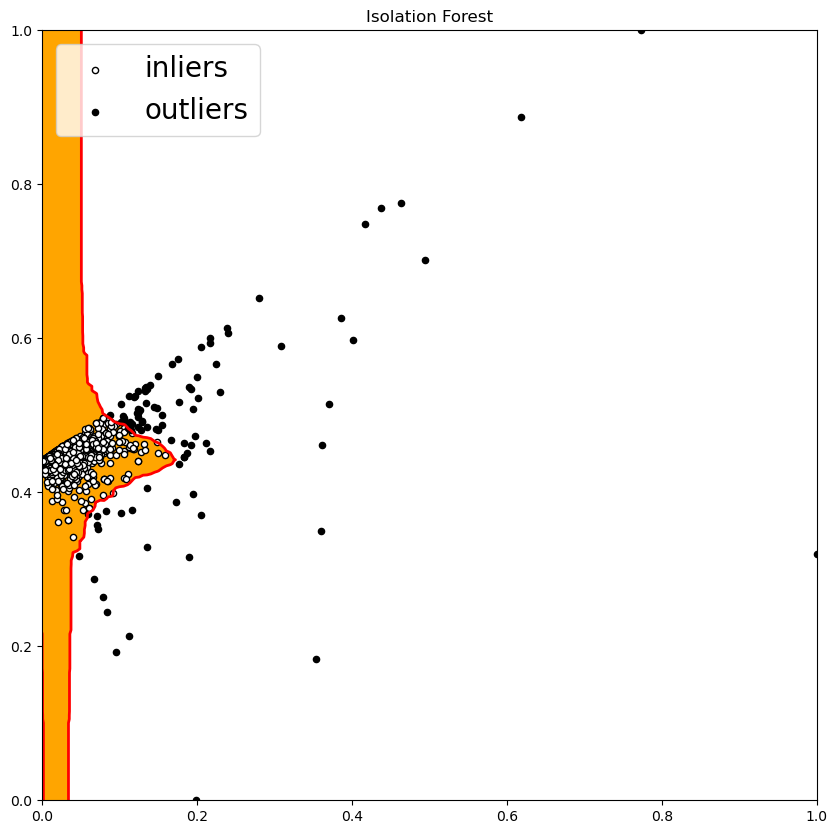

No. of OUTLIERS :  91 No. of INLIERS :  9903 K Nearest Neighbors (KNN)


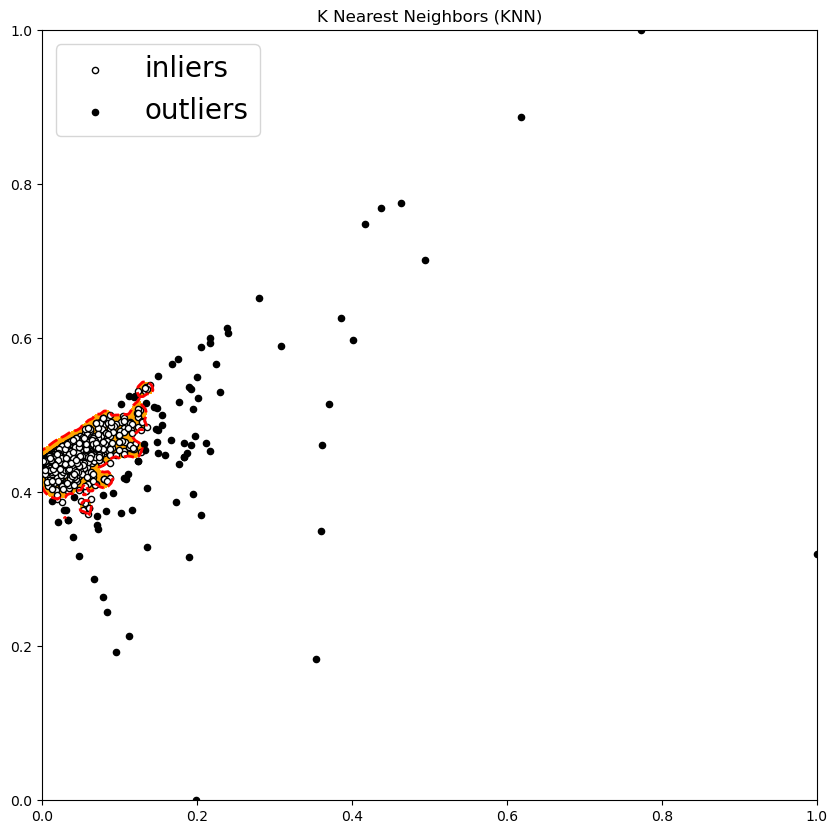

No. of OUTLIERS :  72 No. of INLIERS :  9922 Average KNN


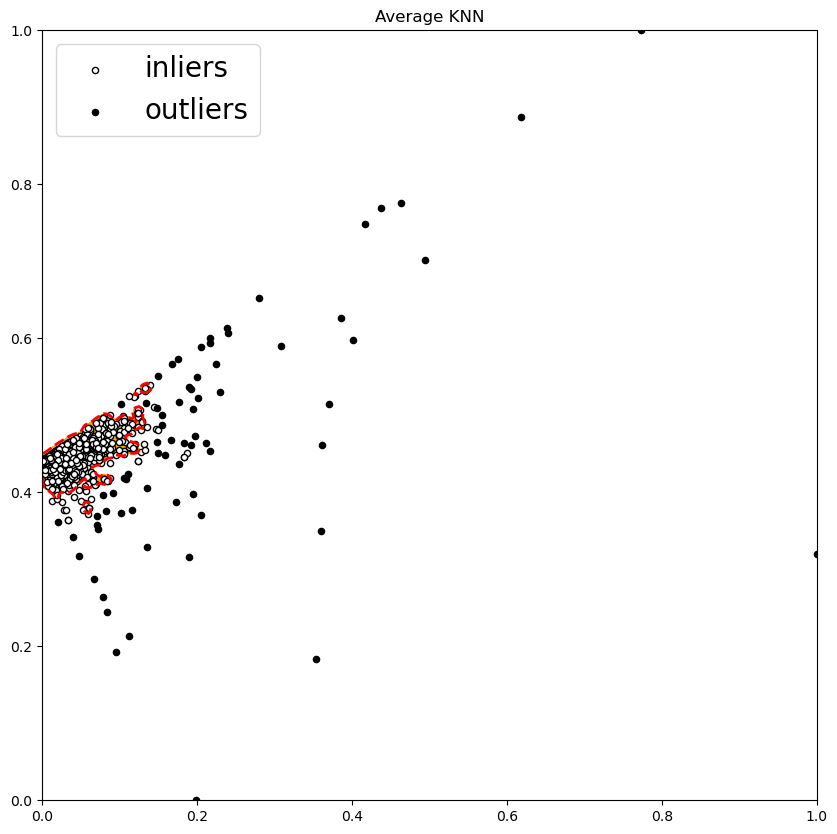

In [41]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # Copy of dataframe
    df1['outlier'] = y_pred.tolist()
    
    # Inlier feature 1, Inlier feature 2
    In_Feat1 =  np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
    In_Feat2 =  np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
    # Outlier feature 1, Outlier feature 2
    Out_Feat1 =  df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
    Out_Feat2 =  df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
    
    print('No. of OUTLIERS : ',n_outliers,'No. of INLIERS : ',n_inliers, clf_name)
    
    # Threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
    
    # Decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    
    # draw red contour line where anomaly score is equal to threshold = Learned decision boundary
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
    
    b = plt.scatter(In_Feat1, In_Feat2, c='white', s=20, edgecolor='k')
    
    c = plt.scatter(Out_Feat1, Out_Feat2, c='black', s=20, edgecolor='k')

    plt.axis('tight')  
    
    #loc=2 is used for the top left corner 
    plt.legend(
        [b, c],
        ['inliers', 'outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()


In [42]:
df_out = df[df1["outlier"] == 1]

In [43]:
df_out.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920
262,263,US-2014-106992,2014-09-19,2014-09-21,Second Class,SB-20290,Sean Braxton,Corporate,United States,Houston,...,77036,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,3059.982,3,0.4,-509.9970
263,264,US-2014-106992,2014-09-19,2014-09-21,Second Class,SB-20290,Sean Braxton,Corporate,United States,Houston,...,77036,Central,TEC-MA-10003353,Technology,Machines,Xerox WorkCentre 6505DN Laser Multifunction Pr...,2519.958,7,0.4,-251.9958
318,319,CA-2014-164973,2014-11-04,2014-11-09,Standard Class,NM-18445,Nathan Mautz,Home Office,United States,New York City,...,10024,East,TEC-MA-10002927,Technology,Machines,Canon imageCLASS MF7460 Monochrome Digital Las...,3991.980,2,0.0,1995.9900


In [47]:
df.iloc[1995]

Row ID                                                        1996
Order ID                                            US-2017-147221
Order Date                                     2017-12-02 00:00:00
Ship Date                                      2017-12-04 00:00:00
Ship Mode                                             Second Class
Customer ID                                               JS-16030
Customer Name                                            Joy Smith
Segment                                                   Consumer
Country                                              United States
City                                                       Houston
State                                                        Texas
Postal Code                                                  77036
Region                                                     Central
Product ID                                         OFF-AP-10002534
Category                                           Office Supp

For this particular order, a customer purchased 5 products with total price at 294.62 and profit at lower than -766, with 80% discount. It seems like a clearance. We should be aware of the loss for each product we sell.